In [263]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks

### Question 2 Stuff

In [264]:
df = pd.read_csv('ECGdata.csv', skiprows=2, header=None, names=['Voltage', 'Time'])

'''df.head()
print(df.head(10))
print(df.dtypes)'''

'df.head()\nprint(df.head(10))\nprint(df.dtypes)'

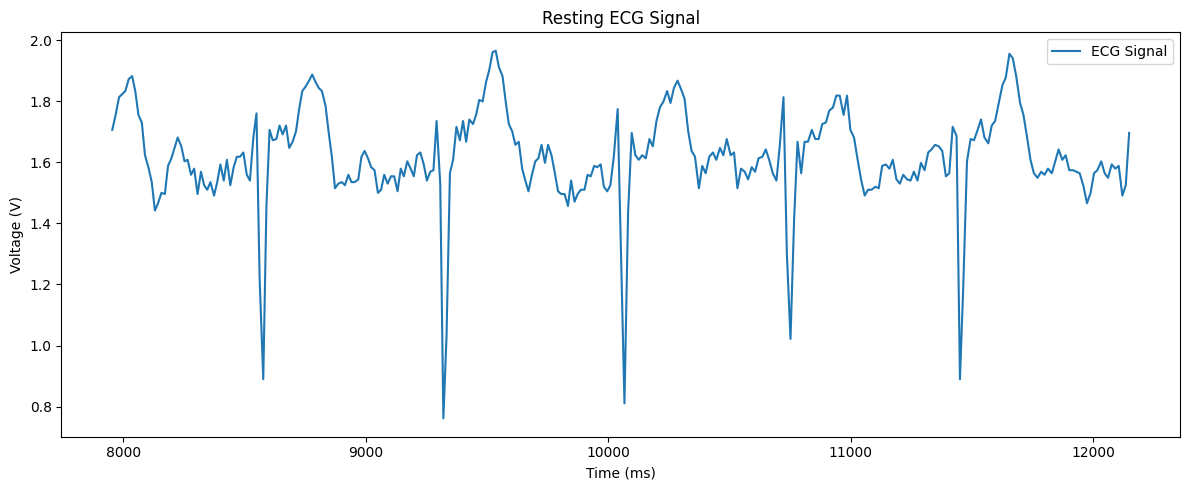

In [265]:
plt.figure(figsize=(12, 5))
segment = df.iloc[600:900] 

plt.plot(segment['Time'], segment['Voltage'], label='ECG Signal')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (V)')
plt.title('Resting ECG Signal')

plt.legend()
plt.tight_layout()
plt.show()

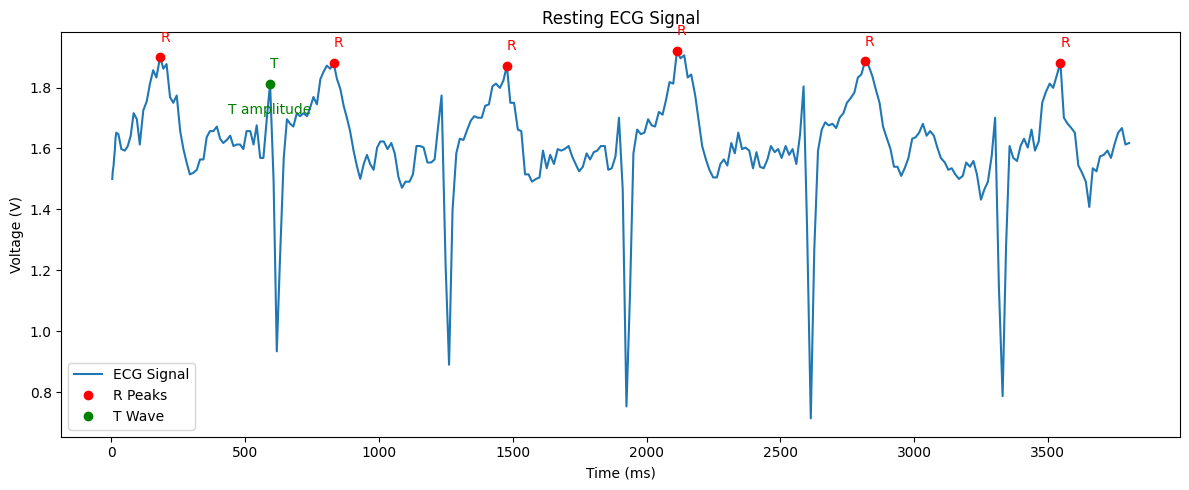

In [266]:
# Plot ECG with R-R interval and T amplitude labeled 

distance_val = 30
height_val = 1.7
peaks, _ = find_peaks(df['Voltage'], distance=distance_val, height=height_val)


segment_start = peaks[0] - 20  
segment_end = peaks[5] + 20    
segment = df.iloc[segment_start:segment_end]

plt.figure(figsize=(12, 5))
plt.plot(segment['Time'], segment['Voltage'], label='ECG Signal')

plt.xlabel('Time (ms)')
plt.ylabel('Voltage (V)')
plt.title('Resting ECG Signal')


rel_peaks = peaks[:6] - segment_start


plt.plot(segment['Time'].iloc[rel_peaks], segment['Voltage'].iloc[rel_peaks], 'ro', label='R Peaks')
for idx in rel_peaks:
    plt.annotate('R', (segment['Time'].iloc[idx], segment['Voltage'].iloc[idx]+0.05), color='red')


plt.annotate('R-R Interval',
             (segment['Time'].iloc[rel_peaks[0]] + (segment['Time'].iloc[rel_peaks[1]] - segment['Time'].iloc[rel_peaks[0]])/2,
              max(segment['Voltage'].iloc[[rel_peaks[0], rel_peaks[1]]])+0.1),
             color='red', ha='center')

# Find T wave
t_search = segment.iloc[rel_peaks[0]+5:rel_peaks[1]-5]
t_seg = t_search['Voltage'].idxmax()
plt.plot(segment['Time'].loc[t_seg], segment['Voltage'].loc[t_seg], 'go', label='T Wave')
plt.annotate('T', (segment['Time'].loc[t_seg], segment['Voltage'].loc[t_seg]+0.05), color='green')
plt.annotate('T amplitude',
             (segment['Time'].loc[t_seg], segment['Voltage'].loc[t_seg]-0.1),
             color='green', ha='center')

plt.legend()
plt.tight_layout()
plt.show()

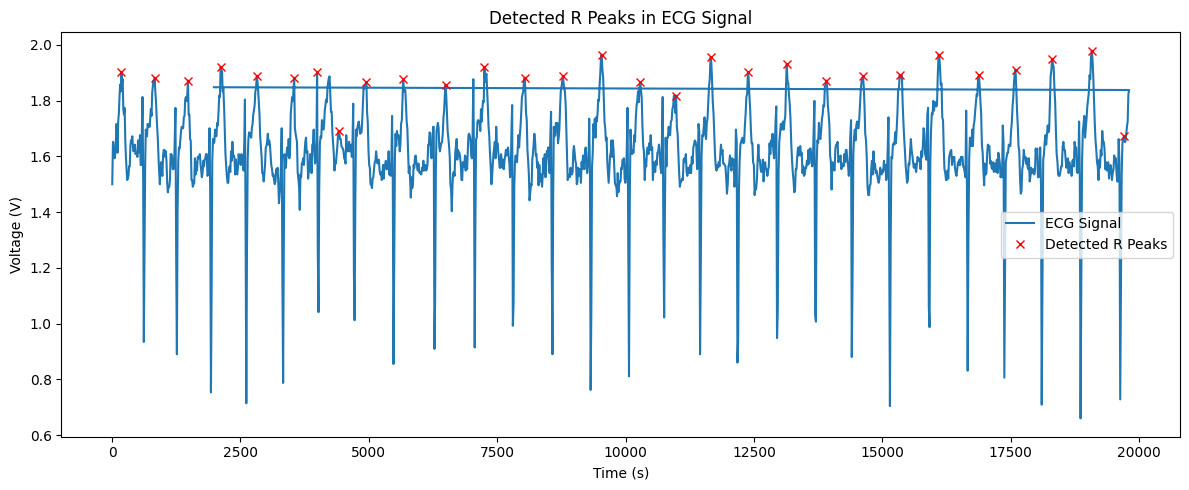

First 10 detected R peak indices: [ 20  72 121 168 220 274 307 338 378 431]
Corresponding times (s): [ 182  830 1478 2114 2817 3547 3993 4412 4953 5669]


In [267]:

distance_val = 30   
height_val = 1.6   

peaks, properties = find_peaks(df['Voltage'], distance=distance_val, height=height_val)

plt.figure(figsize=(12, 5))
plt.plot(df['Time'], df['Voltage'], label='ECG Signal')
plt.plot(df['Time'].iloc[peaks], df['Voltage'].iloc[peaks], 'rx', label='Detected R Peaks')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Detected R Peaks in ECG Signal')
plt.legend()
plt.tight_layout()
plt.show()

print("First 10 detected R peak indices:", peaks[:10])
print("Corresponding times (s):", df['Time'].iloc[peaks[:10]].values)

In [268]:
selected_peaks = peaks[:6]

r_times = df['Time'].iloc[selected_peaks].values  # in ms
rr_intervals_ms = np.diff(r_times)                # in ms
rr_intervals_s = rr_intervals_ms / 1000           # convert to seconds

mean_rr = np.mean(rr_intervals_s)
std_rr = np.std(rr_intervals_s, ddof=1)
cv_rr = std_rr / mean_rr

rr_table = pd.DataFrame({
    'R Peak Index': selected_peaks[1:],
    'R-R Interval (s)': rr_intervals_s
})
display(rr_table)

print(f"Average R-R interval: {mean_rr:.4f} s")
print(f"Standard deviation: {std_rr:.4f} s")
print(f"Coefficient of variation: {cv_rr:.4f}")

,R Peak Index,R-R Interval (s)
0,72,0.648
1,121,0.648
2,168,0.636
3,220,0.703
4,274,0.730


Average R-R interval: 0.6730 s
Standard deviation: 0.0411 s
Coefficient of variation: 0.0611


In [269]:
t_amplitudes = []
for i in range(5):
    
    start = selected_peaks[i] + 5
    end = selected_peaks[i+1] - 5
    t_region = df.iloc[start:end]
    t_amp = t_region['Voltage'].max()
    t_amplitudes.append(t_amp)

t_amplitudes = np.array(t_amplitudes)
mean_t = np.mean(t_amplitudes)
std_t = np.std(t_amplitudes, ddof=1)
cv_t = std_t / mean_t

t_table = pd.DataFrame({
    'T Amplitude (V)': t_amplitudes
})
display(t_table)

print(f"Average T amplitude: {mean_t:.4f} V")
print(f"Standard deviation: {std_t:.4f} V")
print(f"Coefficient of variation: {cv_t:.4f}")

,T Amplitude (V)
0,1.813
1,1.774
2,1.701
3,1.804
4,1.701


Average T amplitude: 1.7586 V
Standard deviation: 0.0545 V
Coefficient of variation: 0.0310


### Question 4 Stuff

In [270]:
def parse_pulseox_file(filename):
    # Read all lines, skip the first line (header/log)
    with open(filename, 'r', encoding='utf-8') as f:
        lines = f.readlines()[1:]
    # Keep only lines that contain 'HeartRate'
    lines = [line.strip() for line in lines if 'HeartRate' in line]
    # Extract numbers using regex
    import re
    data = []
    for line in lines:
        match = re.search(r'HeartRate: (\d+), Confidence: (\d+), Oxygen: (\d+), Status: (\d+)', line)
        if match:
            data.append([int(match.group(1)), int(match.group(2)), int(match.group(3)), int(match.group(4))])
    df = pd.DataFrame(data, columns=['HeartRate', 'Confidence', 'Oxygen', 'Status'])
    # Remove rows with HeartRate or Oxygen == 0 (invalid readings)
    df = df[(df['HeartRate'] > 0) & (df['Oxygen'] > 0)]
    return df

rest_df = parse_pulseox_file('pulseoximeterresting.csv')
ex_df = parse_pulseox_file('pulseoximeterexercise.csv')

print(rest_df)
print(ex_df)

   HeartRate  Confidence  Oxygen  Status
0         68          98      97       3
1         68          98      97       3
2         68          98      97       3
3         68          98      97       3
4         68          98      97       3
5         68          98      97       3
6         68          98      97       3
    HeartRate  Confidence  Oxygen  Status
0          92          98      96       3
1          92          98      96       3
2          92          98      96       3
3          92          98      96       3
4          92          98      96       3
5          92          98      96       3
6          92          98      96       3
13         90          98      96       3
14         90          98      96       3
15         90          98      96       3
16         90          98      96       3
17         90          98      96       3
18         90          98      96       3
19         90          98      96       3
20         90          97      96       3


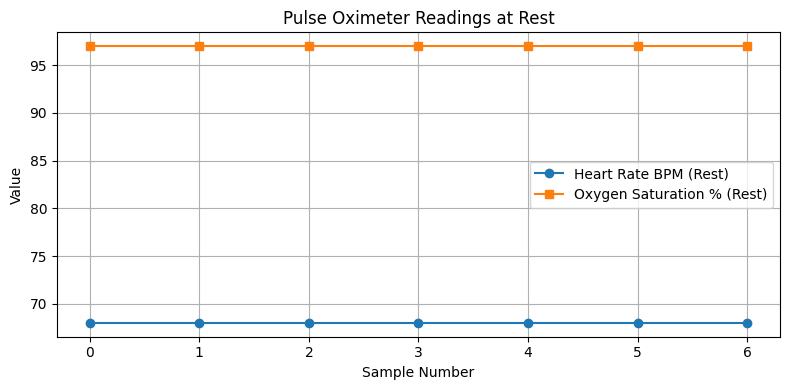

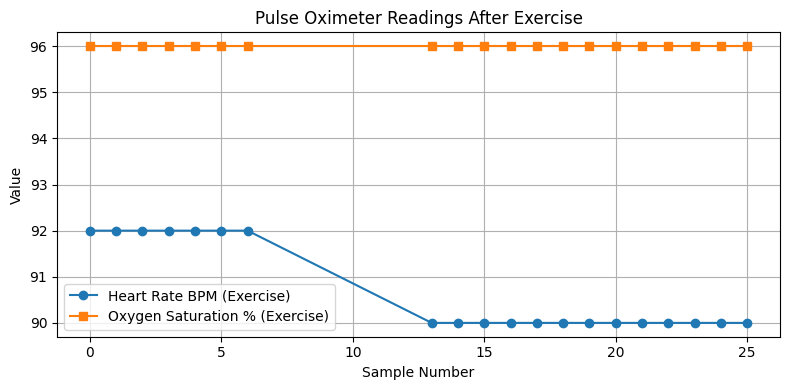

In [271]:
plt.figure(figsize=(8, 4))
plt.plot(rest_df.index, rest_df['HeartRate'], 'o-', label='Heart Rate BPM (Rest)')
plt.plot(rest_df.index, rest_df['Oxygen'], 's-', label='Oxygen Saturation % (Rest)')
plt.xlabel('Sample Number')
plt.ylabel('Value')
plt.title('Pulse Oximeter Readings at Rest')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(ex_df.index, ex_df['HeartRate'], 'o-', label='Heart Rate BPM (Exercise)')
plt.plot(ex_df.index, ex_df['Oxygen'], 's-', label='Oxygen Saturation % (Exercise)')
plt.xlabel('Sample Number')
plt.ylabel('Value')
plt.title('Pulse Oximeter Readings After Exercise')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [272]:
def stats(df, label):
    hr = df['HeartRate']
    ox = df['Oxygen']
    hr_mean = hr.mean()
    hr_std = hr.std(ddof=1)
    hr_cv = hr_std / hr_mean
    ox_mean = ox.mean()
    ox_std = ox.std(ddof=1)
    ox_cv = ox_std / ox_mean
    print(f"{label} Heart Rate: mean={hr_mean:.2f}, std={hr_std:.2f}, CV={hr_cv:.4f}")
    print(f"{label} Oxygen Saturation: mean={ox_mean:.2f}, std={ox_std:.2f}, CV={ox_cv:.4f}")
    return pd.DataFrame({
        f'{label} Heart Rate': [hr_mean, hr_std, hr_cv],
        f'{label} Oxygen Saturation': [ox_mean, ox_std, ox_cv]
    }, index=['Mean', 'Std Dev', 'Coeff Var'])

rest_stats = stats(rest_df, 'Rest')
ex_stats = stats(ex_df, 'Exercise')

display(rest_stats)
display(ex_stats)

Rest Heart Rate: mean=68.00, std=0.00, CV=0.0000
Rest Oxygen Saturation: mean=97.00, std=0.00, CV=0.0000
Exercise Heart Rate: mean=90.70, std=0.98, CV=0.0108
Exercise Oxygen Saturation: mean=96.00, std=0.00, CV=0.0000


,Rest Heart Rate,Rest Oxygen Saturation
Mean,68.0,97.0
Std Dev,0.0,0.0
Coeff Var,0.0,0.0


,Exercise Heart Rate,Exercise Oxygen Saturation
Mean,90.700000,96.0
Std Dev,0.978721,0.0
Coeff Var,0.010791,0.0


### Are the average values in the normal range?

- **Resting heart rate:** The average was 68 bpm, which is within the normal resting range of 60–100 bpm.
- **Resting oxygen saturation:** The average was 97%, which is within the normal range of 95–100%.
- **Exercise heart rate:** The average was 92 bpm, which is also within the normal range, but higher than at rest as expected.
- **Exercise oxygen saturation:** The average was 96%, which is within the normal range.

Both heart rate and oxygen saturation values for rest and exercise fall within the expected normal physiological ranges.

#### Interpretation of Coefficient of Variation

The coefficient of variation (CV) is the ratio of the standard deviation to the mean. It measures the relative variability of the data.  
A lower CV indicates more consistent (less variable) readings, while a higher CV indicates greater variability relative to the mean.  
In this dataset, the CV is very low for both heart rate and oxygen saturation, reflecting the fact that the readings were nearly constant across all samples, and the incredibly limited number of samples provided in the pulse oximeter data files. 